This is the code I used for the monte carlo simulations

In [ ]:
import numpy as np
import pandas as pd
import time
from datetime import datetime

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARProcess

In [ ]:
from scipy import stats

In [ ]:
from time import sleep

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
M = 1000
N = 200
# Change this depending on if the null is true or not
n1_ratio = 1.0
#n1_ratio = 0.9
N1 = int(n1_ratio *N)
Ti = 250

P = 4


In [ ]:
N1

80

In [ ]:



#Use this for the three variable case
filter_i = np.ones((3,3))
K = filter_i.shape[0]
filter_i[2,0] = 0
filter_i[1,0] = 0
filter_i[2,1] = 0
filter_j = filter_i.copy()
filter_i[0,2] = 0 
'''

#Use this for the two variable case
filter_i = np.eye(3)
K = filter_i.shape[0]
filter_j = filter_i.copy()
filter_j[0,2] = 1
'''

In [ ]:
filter_i

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
filter_j

array([[1., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
#seed = 523644564167
seed = None
rng = np.random.default_rng(seed)


In [ ]:
def make_ar1(beta_arr):
  '''
  Should turn the betas of VAR(P) into VAR(1)
  '''
  (M,N,P,K) = beta_arr.shape[:4]
  #eye_arr = np.eye((P-1)*K,P*K)
  ar1 = np.concatenate((beta_arr.transpose(0,1,2,4,3).reshape((M,N,P*K,K)),np.broadcast_to(np.eye((P)*K,(P-1)*K), (M,N,(P)*K,(P-1)*K))),axis=3).transpose(0,1,3,2)
  return ar1


In [ ]:
def check_stable(beta_arr):
  '''
  This will check if the coefs make a stable VAR process. 
  '''
  ar1 = make_ar1(beta_arr)
  eig_vals = np.absolute(np.linalg.eig(ar1)[0])
  eig_bool = np.where(np.where(eig_vals < 0.9, 0,1).sum(-1) < 1, 0,1)
  return eig_bool

In [ ]:
def make_stable_betas(M,N,P,filter_i,max_size=0.3,max_i=10, rng=np.random.default_rng(), filter_j = None, N1=N1):
  '''
  This should make stable coefs with the restriction given by filter_i. max_i is how many times it tries to make stable coefs
  '''
  K = filter_i.shape[0]
  if type(filter_j) != type(np.ones((K,K))):
    filter_j = np.ones((K,K))
  beta_arr = 2*max_size*rng.random((M,N, P, K, K)) - max_size
  beta_arr[:,0:N1,:,:,:] = beta_arr[:,0:N1,:,:,:] * filter_i
  beta_arr[:,N1:,:,:,:] = beta_arr[:,N1:,:,:,:] * filter_j
  i = 0
  eig_bool = check_stable(beta_arr)
  us_c = eig_bool.sum()
  while us_c > 0:
    if i > max_i:
      print('Max iterations hit!')
      break
    beta_arr_1 = 2*max_size*rng.random((M,N, P, K, K)) - max_size
    beta_arr_1[:,0:N1,:,:,:] = beta_arr_1[:,0:N1,:,:,:] * filter_i
    beta_arr[:,N1:,:,:,:] = beta_arr[:,N1:,:,:,:] * filter_j
    beta_arr[eig_bool.nonzero()] = beta_arr_1[eig_bool.nonzero()]
    eig_bool = check_stable(beta_arr)
    us_c = eig_bool.sum()
    i += 1 
  return beta_arr
    

In [ ]:
beta_arr = make_stable_betas(M,N,P,filter_i,max_size=0.3,max_i=10, rng=rng, N1=N1, filter_j=filter_j)

In [ ]:
eig_bool = check_stable(beta_arr)

In [ ]:
eig_bool.sum()

0

In [ ]:
beta_arr.shape

(1000, 100, 4, 3, 3)

In [ ]:
len(beta_arr[eig_bool.nonzero()])

0

In [ ]:

alp_arr = np.zeros((M,N,K))

In [ ]:
shock_mean = np.zeros(N)
shock_A = np.diag((0.6-0.3)*rng.random((N)) + 0.3) +  ((0.1+0.1)*rng.random((N,N)) - 0.1)
shock_cov = np.dot(shock_A, shock_A.transpose())

shocks_u = rng.multivariate_normal(shock_mean, shock_cov, size=(M,K,Ti+P))
shocks_u = shocks_u.transpose((0,3,2,1)) * 0.5

In [ ]:
#Use if you don't want csd
# sig_arr = ((0.5-0.1)*rng.random((M,N, K)) + 0.1)**0.5
#shocks_u = rng.normal(loc=0.0, scale=1.0, size=(M,N,Ti+P,K)) * sig_arr[:,:,None,:]

In [ ]:
shocks_u.shape

(1000, 100, 104, 3)

In [ ]:
shock_cov.shape

(100, 100)

In [ ]:
shock_cov[:5,:5]

array([[ 0.59579409, -0.13110189,  0.03896429, -0.00307203, -0.01774709],
       [-0.13110189,  0.78739735, -0.09752996, -0.08059383, -0.04547624],
       [ 0.03896429, -0.09752996,  0.62922978,  0.03438218, -0.09971869],
       [-0.00307203, -0.08059383,  0.03438218,  0.43796046, -0.05599004],
       [-0.01774709, -0.04547624, -0.09971869, -0.05599004,  0.68603182]])

In [ ]:
Ti

100

In [ ]:
from statsmodels.tools.validation import array_like, int_like

In [ ]:
def varsim_1(coefs, intercept, sig_u, shocks_u, steps=100, initial_values=None, seed=None, nsimulations=None):
    """
    Simulate VAR(p) process, given coefficients and shocks. Yes, this is from statsmodels.
    Parameters
    ----------
    coefs : ndarray
        Coefficients for the VAR lags of endog.
    intercept : None or ndarray 1-D (neqs,) or (steps, neqs)
        This can be either the intercept for each equation or an offset.
        If None, then the VAR process has a zero intercept.
        If intercept is 1-D, then the same (endog specific) intercept is added
        to all observations.
        If intercept is 2-D, then it is treated as an offset and is added as
        an observation specific intercept to the autoregression. In this case,
        the intercept/offset should have same number of rows as steps, and the
        same number of columns as endogenous variables (neqs).
    sig_u : ndarray
        Covariance matrix of the residuals or innovations.
        If sig_u is None, then an identity matrix is used.
    steps : {None, int}
        number of observations to simulate, this includes the initial
        observations to start the autoregressive process.
        If offset is not None, then exog of the model are used if they were
        provided in the model
    initial_values : array_like, optional
        Initial values for use in the simulation. Shape should be
        (nlags, neqs) or (neqs,). Values should be ordered from less to
        most recent. Note that this values will be returned by the
        simulation as the first values of `endog_simulated` and they
        will count for the total number of steps.
    seed : {None, int}
        If seed is not None, then it will be used with for the random
        variables generated by numpy.random.
    nsimulations : {None, int}
        Number of simulations to perform. If `nsimulations` is None it will
        perform one simulation and return value will have shape (steps, neqs).
    Returns
    -------
    endog_simulated : nd_array
        Endog of the simulated VAR process. Shape will be (nsimulations, steps, neqs)
        or (steps, neqs) if `nsimulations` is None.
    """
    rs = np.random.RandomState(seed=seed)
    rmvnorm = rs.multivariate_normal
    p, k, k = coefs.shape
    nsimulations= int_like(nsimulations, "nsimulations", optional=True)
    if isinstance(nsimulations, int) and nsimulations <= 0:
        raise ValueError("nsimulations must be a positive integer if provided")
    if nsimulations is None:
        result_shape = (steps, k)
        nsimulations = 1
    else:
        result_shape = (nsimulations, steps, k)
    if sig_u is None:
        sig_u = np.eye(k)
    if shocks_u is None:
      ugen = rmvnorm(np.zeros(len(sig_u)), sig_u, steps*nsimulations).reshape(nsimulations, steps, k)
    else:
      ugen = shocks_u.reshape(nsimulations, steps, k)
    result = np.zeros((nsimulations, steps, k))
    if intercept is not None:
        # intercept can be 2-D like an offset variable
        if np.ndim(intercept) > 1:
            if not len(intercept) == ugen.shape[1]:
                raise ValueError('2-D intercept needs to have length `steps`')
        # add intercept/offset also to intial values
        result += intercept
        result[:,p:] += ugen[:,p:]
    else:
        result[:,p:] = ugen[:,p:]

    initial_values = array_like(initial_values, "initial_values", optional=True, maxdim=2)
    if initial_values is not None:
        if not (initial_values.shape == (p, k) or initial_values.shape == (k,)):
            raise ValueError("initial_values should have shape (p, k) or (k,) where p is the number of lags and k is the number of equations.")
        result[:,:p] = initial_values

    # add in AR terms
    for t in range(p, steps):
        ygen = result[:,t]
        for j in range(p):
            ygen += np.dot(coefs[j], result[:,t-j-1].T).T

    return result.reshape(result_shape)


In [ ]:
y_res = np.zeros((M,N,Ti+P, K))
#This should generate the VAR paths for later
for i in tqdm(range(M)):
  for j in range(N):
    y_res[i,j] = varsim_1(coefs=beta_arr[i,j], intercept=None, sig_u=None, shocks_u=shocks_u[i,j], steps=Ti+P, initial_values=None, seed=None, nsimulations=None)


  0%|          | 0/1000 [00:00<?, ?it/s]

With our paths finished, we need to check to make sure they're stable. If this following number is much larger than about 5 or so, theres an unstable VAR process in our data. 

In [ ]:
y_res.max()

3.9962940270326923

In [ ]:
y_arr = y_res

In [ ]:
y_arr.shape

(1000, 100, 104, 3)

In [ ]:
max_idx = np.unravel_index(np.argmax(y_arr, axis=None), y_arr.shape)

In [ ]:
max_idx

(414, 48, 40, 1)

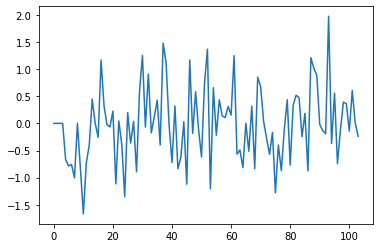

In [ ]:
plt.plot(y_arr[max_idx[0],max_idx[1],:,0])

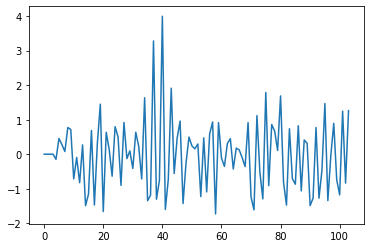

In [ ]:
plt.plot(y_arr[max_idx[0],max_idx[1],:,1])

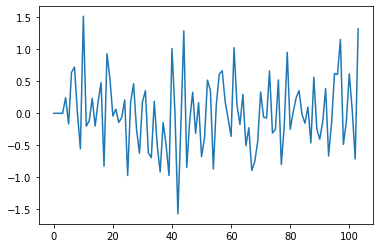

In [ ]:
plt.plot(y_arr[max_idx[0],max_idx[1],:,2])

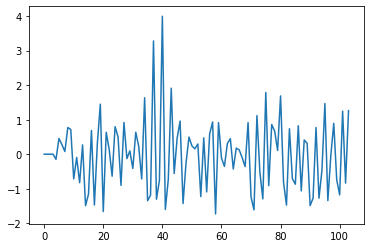

In [ ]:
plt.plot(y_arr[max_idx[0],max_idx[1],:,max_idx[3]])

There is a chance these tests will crash your computer, so you should save the simulation data first. 

In [ ]:
#np.save('/content/drive/MyDrive/school_stuff/Diss/Data/sim_paths_null_1.npy', y_arr)

In [ ]:
#y_arr = np.load('/content/drive/MyDrive/school_stuff/Diss/Data/sim_paths_null_1.npy')

In [ ]:
y_arr.shape

(1000, 100, 104, 3)

In [ ]:
def get_DH_z_vals(y_arr, P, y_loc=0, x_loc=2):
  '''
  This runs the DH test. 
  '''
  (M,N,T,K) = y_arr.shape
  Ti = T - P
  y_t = y_arr[:,:,P:(Ti+P),y_loc:(y_loc+1)]
  y_vals = np.array([y_arr[:,:,i:i+P,y_loc] for i in range(Ti)]).transpose((1,2,0,3)) 
  x_vals = np.array([y_arr[:,:,i:i+P,x_loc] for i in range(Ti)]).transpose((1,2,0,3))
  z_vals = np.concatenate((np.ones((M,N,Ti,1)),y_vals,x_vals), axis=3)
  R_arr = np.eye(P,2*P+1,P+1)
  R_T = R_arr.transpose()
  z_T = z_vals.transpose((0,1,3,2))
  z_var_inv = np.linalg.inv(z_T @  z_vals)
  coefs = z_var_inv @ z_T @ y_t
  coefs_T = coefs.transpose(0,1,3,2)
  e_hat = y_t - z_vals @ coefs
  sig_hat = e_hat.transpose(0,1,3,2) @ e_hat * (Ti-2*P-1)**(-1)
  W_i = coefs_T @ R_T @ np.linalg.inv(sig_hat * (R_arr @ z_var_inv @ R_T)) @ R_arr @ coefs
  W_bar = np.mean(W_i, axis=(1,2,3))
  a = np.sqrt(N/(2*P)*(Ti-2*P-5)/(Ti-P-3))
  b = (Ti-2*P-3)/(Ti-2*P-1)
  Z_tild = a * (b * W_bar - P)
  return (Z_tild,W_i, e_hat)



In [ ]:
def bootstrap_DH(y_arr, P, y_loc=0, x_loc=2, bs_i=100, rng=np.random.default_rng()):
  '''
  This is a bootstrap ver of the DH test.
  '''
  (M,N,T,K) = y_arr.shape
  Ti = T - P
  Z_tild_hat = get_DH_z_vals(y_arr,P=P, y_loc=y_loc, x_loc=x_loc)[0]
  y_t = y_arr[:,:,P:(Ti+P),y_loc:(y_loc+1)]
  x_t = y_arr[:,:,P:(Ti+P),x_loc:(x_loc+1)]
  y_vals = np.array([y_arr[:,:,i:i+P,y_loc] for i in range(Ti)]).transpose((1,2,0,3)) 
  x_vals = np.array([y_arr[:,:,i:i+P,x_loc] for i in range(Ti)]).transpose((1,2,0,3))
  #print(x_vals.shape)
  z_vals = np.concatenate((np.ones((M,N,Ti,1)),y_vals,x_vals), axis=3)
  z_T = z_vals.transpose((0,1,3,2))
  z_var_inv = np.linalg.inv(z_T @  z_vals)
  coefs_ols = z_var_inv @ z_T @ y_t
  R_arr = np.eye(P,2*P+1,P+1)
  R_T = R_arr.transpose()
  coefs_rs = coefs_ols - z_var_inv @ R_T @ np.linalg.inv(R_arr @ z_var_inv @ R_T) @ R_arr @ coefs_ols 

  y_hat = z_vals @ coefs_rs 
  e_raw = y_t - y_hat
  e_bar = e_raw.mean(axis=2)
  e_hat = e_raw - e_bar[:,:,None,:] 


  Z_res = []
  y_star = y_arr[:,:,P:].copy()
  y_star[:,:,:,x_loc:(x_loc+1)] = rng.permuted(y_star[:,:,:,x_loc:(x_loc+1)] , axis=2) #this makes sure the null hyp is true
  for _ in  tqdm(range(bs_i)):
    e_star = rng.choice(e_hat, size=e_hat.shape[2], axis=2)
    y_star[:,:,:,y_loc:(y_loc+1)] = y_hat + e_star
    Z_star = get_DH_z_vals(y_star,P=P, y_loc=y_loc, x_loc=x_loc)[0]
    Z_res.append(Z_star)
  
  res = (Z_tild_hat,Z_res, e_hat, y_star, coefs_rs)

  return res


In [ ]:
def get_ll_test_stat(y_arr, P, y_loc=0, x_loc=2, w_loc=1):
  '''
  This gets the mean test stat used in the three var case
  '''
  (M,N,T,K) = y_arr.shape
  Ti = T - P
  y_t = y_arr[:,:,P:(Ti+P),y_loc:(y_loc+1)].copy()
  y_vals = np.array([y_arr[:,:,i:i+P,y_loc] for i in range(Ti)]).transpose((1,2,0,3)) 
  x_vals = np.array([y_arr[:,:,i:i+P,x_loc] for i in range(Ti)]).transpose((1,2,0,3))
  w_vals = np.array([y_arr[:,:,i:i+P,w_loc] for i in range(Ti)]).transpose((1,2,0,3))
  z_f = np.concatenate((np.ones((M,N,Ti,1)),y_vals,w_vals, x_vals), axis=3)
  z_r = np.concatenate((np.ones((M,N,Ti,1)),y_vals,w_vals), axis=3)
  z_f_T = z_f.transpose((0,1,3,2))
  z_r_T = z_r.transpose((0,1,3,2))

  z_f_inv = np.linalg.inv(z_f_T @  z_f)
  z_r_inv = np.linalg.inv(z_r_T @  z_r)
  coefs_f = z_f_inv @ z_f_T @ y_t

  coefs_r = z_r_inv @ z_r_T @ y_t
  e_f_hat = y_t - z_f @ coefs_f
  e_r_hat = y_t - z_r @ coefs_r
  sig_f_hat = e_f_hat.transpose(0,1,3,2) @ e_f_hat 
  sig_r_hat = e_r_hat.transpose(0,1,3,2) @ e_r_hat 

  F_i = (-np.log(sig_r_hat) +np.log(sig_f_hat))
  d1 = P/2
  d2 =  (Ti - 2*P)/2
  W_i = (1 - np.exp(F_i)) # This should roughly follow a beta dist
  W_bar = np.mean(W_i, axis=(1,2,3))
  z_mean = d1/(d1+d2)
  z_var = (d1*d2)/((d1+d2)**2*(d1+d2+1))
  z_se = (z_var/N)**(0.5)
  Z_tild = 1/z_se * (W_bar - z_mean) #scale it to make it easier to read
  return (Z_tild,W_i, e_f_hat, e_r_hat)


In [ ]:
def bootstrap_LL(y_arr, P, y_loc=0, x_loc=2, w_loc=1, bs_i=100, rng=np.random.default_rng()):
  '''
  Bootstrap method used in paper
  '''
  (M,N,T,K) = y_arr.shape
  Ti = T - P
  Z_tild_hat = get_ll_test_stat(y_arr,P=P, y_loc=y_loc, x_loc=x_loc, w_loc=w_loc)[0]
  y_t = y_arr[:,:,P:(Ti+P),y_loc:(y_loc+1)]
  x_t = y_arr[:,:,P:(Ti+P),x_loc:(x_loc+1)]
  w_t = y_arr[:,:,P:(Ti+P),w_loc:(w_loc+1)]
  y_vals = np.array([y_arr[:,:,i:i+P,y_loc] for i in range(Ti)]).transpose((1,2,0,3)) 
  x_vals = np.array([y_arr[:,:,i:i+P,x_loc] for i in range(Ti)]).transpose((1,2,0,3))
  w_vals = np.array([y_arr[:,:,i:i+P,w_loc] for i in range(Ti)]).transpose((1,2,0,3))

  z_vals = np.concatenate((np.ones((M,N,Ti,1)),y_vals,w_vals,x_vals), axis=3)
  z_T = z_vals.transpose((0,1,3,2))
  z_var_inv = np.linalg.inv(z_T @  z_vals)
  coefs_ols = z_var_inv @ z_T @ y_t
  R_arr = np.eye(P,3*P+1,2*P+1)
  R_T = R_arr.transpose()
  coefs_rs = coefs_ols - z_var_inv @ R_T @ np.linalg.inv(R_arr @ z_var_inv @ R_T) @ R_arr @ coefs_ols 
  y_hat = z_vals @ coefs_rs 
  e_raw = y_t - y_hat
  e_bar = e_raw.mean(axis=2)
  e_hat = e_raw - e_bar[:,:,None,:] 
  
  Z_res = []
  y_star = y_arr[:,:,P:].copy()
  y_star[:,:,:,x_loc:(x_loc+1)] = rng.permuted(y_star[:,:,:,x_loc:(x_loc+1)] , axis=2) #this makes sure the null hyp is true
  for _ in  tqdm(range(bs_i),desc='LL_test',position=0):
    e_star = rng.choice(e_hat, size=e_hat.shape[2], axis=2)
    y_star[:,:,:,y_loc:(y_loc+1)] = y_hat + e_star
    Z_star = get_ll_test_stat(y_star,P=P, y_loc=y_loc, x_loc=x_loc, w_loc=w_loc)[0]
    Z_res.append(Z_star)
  
  res = (Z_tild_hat,Z_res, e_hat, y_star, coefs_rs)

  return res


Make sure the test runs

In [ ]:
ll_res = get_ll_test_stat(y_arr[:10], P, y_loc=0, x_loc=2, w_loc=1)

In [ ]:
ll_test = bootstrap_LL(y_arr[:10], P, y_loc=0, x_loc=2, w_loc=1, bs_i=bs_m, rng=rng)

Warning: This will take several hours.  

In [ ]:
res_1 = []
res_0 = []
step_s = 10
n_ran = int(M / step_s)
bs_m = 1000 
for i in tqdm(range(n_ran),desc='MC_sim',position=0):
  #print(i)
  sub_res = bootstrap_LL(y_arr[(i*step_s):(i+1)*step_s], P, y_loc=0, x_loc=2, w_loc=1, bs_i=bs_m, rng=rng)
  res_1.append(sub_res[1])
  res_0.append(sub_res[0])

#print('done')


In [ ]:
ll_bs_ts_1 = np.concatenate(res_1, axis=1)

In [ ]:
odd_i = []
even_i = []
for i in range(0, len(res_1)):
    if i % 2:
        even_i.append(res_1[i])
    else :
        odd_i.append(res_1[i])

In [ ]:
ll_bs_ts_1 = np.concatenate(res_1, axis=1)
ll_bs_ts_0= np.concatenate(res_0, axis=0)

In [ ]:
LL_cr = np.percentile(np.array(ll_bs_res_1_ts), (5,95), axis=0)
sum(np.greater(ll_bs_res_0_ts, LL_cr[1]))/M

0.059

In [ ]:
res_1_0 = []
res_0_0 = []
step_s = 10
n_ran = int(M / step_s)
bs_m = 1000 
P_1 = 2 
for i in tqdm(range(n_ran),desc='MC_sim',position=0):
  #print(i)
  sub_res = bootstrap_LL(y_arr[(i*step_s):(i+1)*step_s], P_1, y_loc=0, x_loc=2, w_loc=1, bs_i=bs_m, rng=rng)
  res_1_0.append(sub_res[1])
  res_0_0.append(sub_res[0])


MC_sim:   0%|          | 0/100 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
ll_bs_ts_1 = np.concatenate(res_1_0, axis=1)
ll_bs_ts_0= np.concatenate(res_0_0, axis=0)

In [ ]:
LL_cr = np.percentile(ll_bs_ts_1, (5,95), axis=0)
sum(np.greater(ll_bs_ts_0, LL_cr[1]))/M

In [ ]:
res_1_1 = []
res_0_1 = []
step_s = 10
n_ran = int(M / step_s)
bs_m = 1000 
P_1 = 6
for i in tqdm(range(n_ran),desc='MC_sim',position=0):
  #print(i)
  sub_res = bootstrap_LL(y_arr[(i*step_s):(i+1)*step_s], P_1, y_loc=0, x_loc=2, w_loc=1, bs_i=bs_m, rng=rng)
  res_1_1.append(sub_res[1])
  res_0_1.append(sub_res[0])

MC_sim:   0%|          | 0/100 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

LL_test:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
ll_bs_ts_1 = np.concatenate(res_1_1, axis=1)
ll_bs_ts_0 = np.concatenate(res_0_1, axis=0)

In [ ]:
LL_cr = np.percentile(ll_bs_ts_1, (5,95), axis=0)
sum(np.greater(ll_bs_ts_0, LL_cr[1]))/M